# Lab 3: MDP and QMDP
This lab aims to show you how to formulate a problem as an MDP (POMDP) and solve it using value iteration, policy iteration, and approximated solution for POMDP such as QMDP.

## 1. MDP
### Task 1.1: MDP formulation
We provide you with a class `MDP()` to help you easily formulate your MDP problem. Refer to your lab handout for instructions on how to use the class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from mdp import MDP

Test out the class with the simple two-state problem in the handout

In [2]:
class TwoStateMDP(MDP):
    def __init__(self):
        self.states = [["s1", "s2"]]
        self.actions = ["a0", "a1"]
        self.gam = 0.9
    
        # call the parent class
        # notice that the state is a list of state variables
        super().__init__(
            states=self.states, actions=self.actions)
        self.populate_data()
    
    def populate_data(self):
        # add all routes from s1
        self.add_route(["s1"],"a0",["s1"])
        self.add_route(["s1"],"a1",["s2"])
        # add all routes from s2
        self.add_route(["s2"],"a0",["s2"])
        self.add_route(["s2"],"a1",["s2"])
        
        # let's populate the reward, assuming r>0 is 0.5
        for a in self.a:
            self.add_reward(["s1"], a, 0.5)
            self.add_reward(["s2"], a, 1.5)

In [3]:
twoStateMDP = TwoStateMDP()
assert twoStateMDP.get_index(["s1"]) == 0, "Something is wrong"
assert twoStateMDP.get_state(0) == [0], "Something is wrong"
assert twoStateMDP.get_real_state_value(0) == ['s1'], "Something is wrong"
print("Everything is correct!")

Everything is correct!


Now let's use the `MDP()` class to formulate our T-intersection problem.

**Task 1.1**: In `populate_data()`, all the probability value for each `self.add_route()` command is missing (denotes `MISSING_VALUE`). Compute the state transition matrix of the T-intersection MDP and fill in the missing `p` values.

In [4]:
class TIntersection(MDP):
    def __init__(self, reward={"forward": -1.0, "stop": -5, "collision": -10, "goal": 5.0}):
        self.states = [
            ["ego_{}".format(x) for x in list(range(1, 6))],
            ["car_{}".format(x) for x in list(range(1, 6))]
        ]
        self.actions = ["forward", "stop"]
        self.gam = 0.9
        super().__init__(
            states=self.states, actions=self.actions, method="add")
        self.reward = reward
        self.populate_data()
    
    def populate_data(self):
        for i in range(1, 6):
            for j in range(1, 6):
                # add route for forward action
                # (i, j) --> (i+1, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(j)], 0.64)
                # (i, j) --> (i+1, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+1, 5))], 0.128)
                # (i, j) --> (i+1, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+2, 5))], 0.032)
                # (i, j) --> (i+2, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(j)], 0.16)
                # (i, j) --> (i+2, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+1, 5))], 0.032)
                # (i, j) --> (i+2, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+2, 5))], 0.008)

                # add route for stop action
                # (i, j) --> (i, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+2, 5))], 0.08)
                # (i, j) --> (i, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+1, 5))], 0.32)
                # (i, j) --> (i, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(j)], 0.6)

                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["forward"])
                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["stop"])
                        
                # check for collision
                if (i in [4, 5]) and (j in [4, 5]):
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["collision"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["collision"])
                elif (i == 5) or (j == 5):
                    # reaching goal
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["goal"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["goal"])


In [5]:
### TEST YOUR CODE
tinter = TIntersection()
init_state = ["ego_1", "car_1"]
init_state_index = tinter.get_index(init_state)
state_transition_matrix = tinter.P[:, 0, init_state_index]
next_state_index = np.where(state_transition_matrix > 0.0)
next_state_p = state_transition_matrix[next_state_index]
assert np.array_equal(next_state_index[0], np.array([1, 2, 6, 7, 11, 12]))
assert np.array_equal(next_state_p, np.array([0.64, 0.16, 0.128, 0.032, 0.032, 0.008]))

print("Correct!")

Correct!


### Task 1.2: MDP value iteration and policy iteration
Now we will write the value iteration function and policy iteration function or an arbitrary MDP that inherits the structure of our MDP class

In [6]:
### TASK 1.2: Write value iteration and policy iteration
def value_iteration(threshold = .001, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    numa, nums, R, P = mdp.get_mdp()
    V_star = np.zeros(nums)
    pi_star = np.zeros(nums)
    prev_V = np.zeros(nums)
    
    ####
    ## YOUR CODE HERE

    ############################
    delta = np.inf
    while True:
        delta = 0
        for s in range(nums):
            qs = []
            for a in range(numa):
                new_val = R[s][a]
                for s_prime in range(nums):
                    new_val += mdp.gam * P[s_prime,s,a] * prev_V[s_prime]
                qs.append(new_val)
            V_star[s] = max(qs)
            pi_star[s] = np.argmax(qs)
            delta = max(delta, abs(V_star[s] - prev_V[s]))
            prev_V[s] = V_star[s]
        if delta < threshold:
            break
    return V_star, pi_star

def policy_eval(policy, threshold = .001, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    numa, nums, R, P = mdp.get_mdp()
    V = np.zeros(nums)
    prev_V = np.zeros(nums)
    
    ####
    ## YOUR CODE HERE
    #raise NotImplementedError("You have not written Policy Evaluation")
    ####
    delta = np.inf
    while True:
        delta = 0
        for s in range(nums):
            a = policy[s] # think about P, s' is an int
            V[s] = R[s][a]
            for s_prime in range(nums):
                V[s]+= mdp.gam * P[s_prime,s,a] * prev_V[s_prime]
            delta = max(delta, abs(V[s] - prev_V[s]))
            prev_V[s] = V[s]
        if delta < threshold:
            break
    return V

def policy_iteration(threshold = .001, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    numa, nums, R, P = mdp.get_mdp()
    # initialize a random policy with length nums and action randomly assigned from numa
    pi_star = np.random.randint(0, numa, nums)
    V_star = policy_eval(pi_star, mdp=mdp)

    #########
    policy_stable = True
    while True:
        for s in range(nums):
            old_act = pi_star[s]
            pi_actions = []
            for a in range(numa):
                pi_sum = R[s][a]
                for s_prime in range(nums):
                    pi_sum += R[s][a] + P[s_prime,s,a] * mdp.gam * (V_star[s_prime])
                pi_actions.append(pi_sum)
            pi_star[s] = np.argmax(pi_actions)
            if old_act != pi_star[s]:
                policy_stable = False
        if not policy_stable:
            V_star = policy_eval(pi_star, mdp=mdp)
            policy_stable = True
        else:
            break

    return V_star, pi_star

Let's test our value iteration and policy iteration on the `TwoStateMDP`. The following is the close-form value function for this simple MDP:

$$
V(s_1) = \frac{r + \gamma}{1 - \gamma} \;\;,\;\; V(s_2) = \frac{1 + r}{1 - \gamma}
$$

In [7]:
### TEST YOUR CODE
V_star, pi_star_value = value_iteration(mdp=twoStateMDP, threshold=1e-10)
r = 0.5
V_calc = [(r + twoStateMDP.gam)/(1-twoStateMDP.gam), (1 + r)/(1-twoStateMDP.gam)]
assert np.max(abs(V_star - V_calc)) < 1e-2, "Value iteration is incorrect"
print("Value iteration is correct!")

V_star, pi_star_policy = policy_iteration(mdp=twoStateMDP, threshold=1e-10)
assert np.max(abs(V_star - V_calc)) < 1e-2, "Policy iteration is incorrect"
print("Policy iteration is correct!")

assert np.array_equal(pi_star_policy, pi_star_value), "Policy and value iteration give different pi star"
print("Policy learned by value iteration: {}".format(pi_star_value))
print("Policy learned by policy iteration: {}".format(pi_star_policy))

Value iteration is correct!
Policy iteration is correct!
Policy learned by value iteration: [1. 0.]
Policy learned by policy iteration: [1 0]


Let's now test the value iteration and policy iteration on our T-intersection MDP

In [8]:
V_star, pi_star = value_iteration(mdp=tinter, threshold=1e-5)
print("V*: {}".format(V_star))
print("pi*: {}".format(pi_star))

V*: [ -4.44753456  -5.86506938  -6.86966343  -3.82061763   2.17938237
   4.0898743    2.72618564   2.72618564 -24.87746894 -18.87746894
  15.41772833  14.65024251  14.65024251 -52.42848935 -46.42848935
  28.34778505  28.26082852  28.26082852 -99.99991792 -99.99991792
  49.99995896  49.99995896  49.99995896 -99.99991792 -99.99991792]
pi*: [0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 0.]


### Task 1.3: Simulate your computed $\pi^*$

We provide you with a class `TintersectionVisualizer()` to visualize your MDP. Simply call the following function to plot the current state:
```python
# initialize the visualizer
vis = TIntersectionVisualizer()
# define the state
state = ["ego_1", "car_1"]
# visualize the state
vis.plot(state)
```

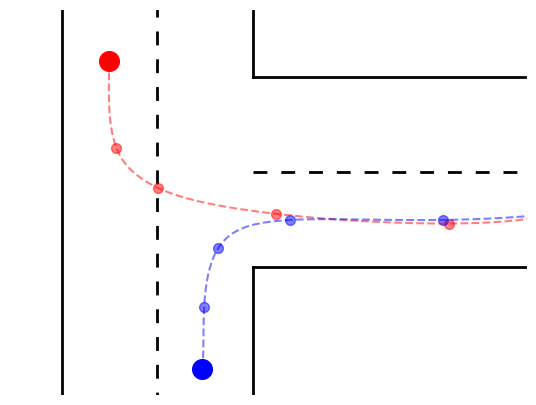

In [9]:
from visualizer import TIntersectionVisualizer
vis = TIntersectionVisualizer()
state = ["ego_1", "car_1"]
vis.plot(state)

Do the following task:
1. Choose an initial state
2. From the computed $V^*(x), \pi^*(x)$, iterate from the chosen initial state gradually until you reach the terminal state, i.e. `["ego_5", "car_5"]`.
3. While iterating, keep track of your state-action pair $(s, a)$. Print out all the state-action pairs that your computed $V^*(x), \pi^*(x)$ navigate you to.

*Hint 1*: For each state and action pair $(s, a)$, the matrix P will show you the probability of $s'$ by calling `P[:, state_index, action_index]`

*Hint 2*: Assuming that you have a list of states `S` and the probability distribution `p` of the states in `S`, you can use `numpy.random.choice(S, p=p)` to sample the next state, given `S` and `p`.

In [59]:
## YOUR CODE HERE
def get_solution(initial_state, mdp: MDP):
    done = False
    state = initial_state 
    state_list = [state]
    print("State: {}\tAction: {}".format(state, None))

    while not done:
        ## YOUR CODE HERE
        # 1. Get index of current state
        # 2. Get next action based on pi_star and state index
        # 3. Get indices of all the possible next states and their transition probabilities
        # 4. Sample next state index, given the transition probabilities
        # 5. Append new state (readable form, e.g. ["ego_1", "car_2"]) to state_list

        # 1. Get index of current state
        state_index = mdp.get_index(state)

        # 2. Get next action based on pi_star and state index
        next_action = pi_star[state_index]

        # 3. attempts
        
        next_state_indices = np.where(mdp.P[:, state_index, int(next_action)] > 0.0)[0]
        next_state_p = mdp.P[:, state_index, int(next_action)][next_state_indices]

        # 4. Sample next state index, given the transition probabilities
        next_state_index = np.random.choice(next_state_indices, p=next_state_p)

        # 5. Append new state (readable form, e.g., ["ego_1", "car_2"]) to state_list
        state = mdp.get_real_state_value(next_state_index)
        state_list.append(state)

        print("State: {}\tAction: {}".format(state, mdp.a[int(next_action)]))

        #state = next_state
        

        if state[0] == "ego_5" or state[1] == "car_5":
            done = True

    return state_list

initial_state = ["ego_1", "car_1"] # choose an initial condition
state_list = get_solution(initial_state, tinter)


State: ['ego_1', 'car_1']	Action: None
State: ['ego_1', 'car_1']	Action: stop
State: ['ego_1', 'car_1']	Action: stop
State: ['ego_1', 'car_2']	Action: stop
State: ['ego_1', 'car_2']	Action: stop
State: ['ego_1', 'car_2']	Action: stop
State: ['ego_1', 'car_3']	Action: stop
State: ['ego_1', 'car_3']	Action: stop
State: ['ego_1', 'car_3']	Action: stop
State: ['ego_1', 'car_4']	Action: stop
State: ['ego_1', 'car_4']	Action: stop
State: ['ego_1', 'car_4']	Action: stop
State: ['ego_1', 'car_4']	Action: stop
State: ['ego_1', 'car_4']	Action: stop
State: ['ego_1', 'car_5']	Action: stop


C:\Users\Clair\miniconda3\envs\mae345\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


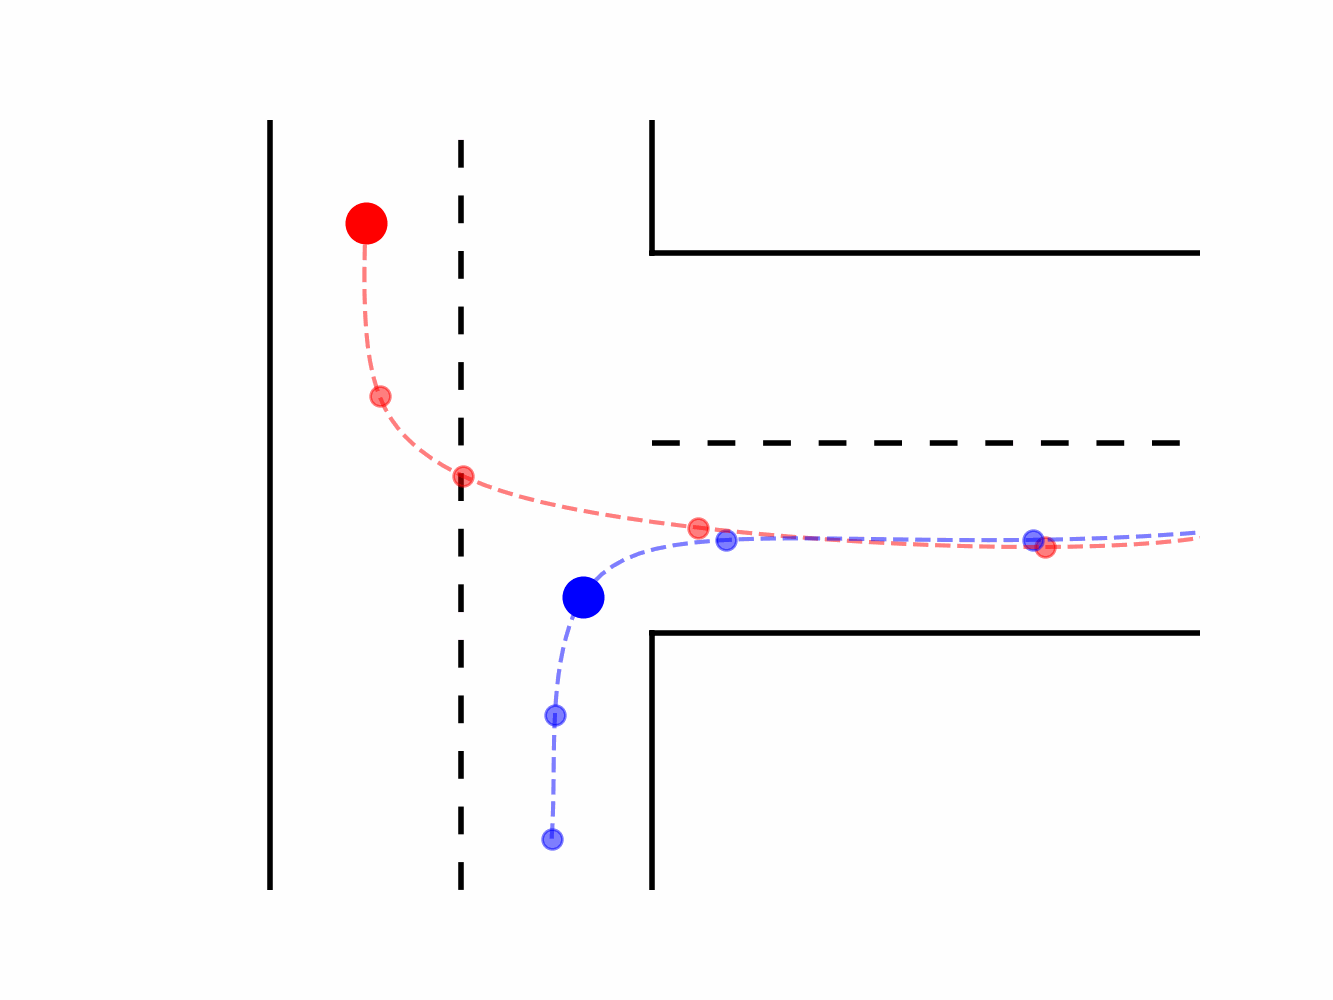

<Figure size 666.667x500 with 0 Axes>

In [46]:
import imageio
from IPython.display import Image

folder = "figures"
sub_folder = "mdp"

fig_prog_folder = os.path.join(folder, sub_folder)
if os.path.exists(fig_prog_folder):
    print("WARNING: Path {} exists, GIF result might be affected with old data".format(fig_prog_folder))
os.makedirs(fig_prog_folder, exist_ok=True)

for i, state in enumerate(state_list):
    vis.plot(state)
    plt.savefig(os.path.join(fig_prog_folder, "{}.png".format(i)), dpi=200)
    plt.clf()

gif_path = os.path.join(fig_prog_folder, 'result.gif')
length = len([i for i in os.listdir(os.path.join(fig_prog_folder)) if ".png" in i])

with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(length):
        print(i, end='\r')
        filename = os.path.join(fig_prog_folder, str(i)+".png")
        image = imageio.imread(filename)
        writer.append_data(image)
Image(open(gif_path,'rb').read(), width=400)

Let's play around with this a bit. Let's change the default reward function of our MDP.

The class `TIntersection()` takes in a dictionary with reward information of the following structure:

```python
TIntersection(reward = {
    "forward": forward_r,
    "stop": stop_r,
    "collision": collision_r,
    "goal": goal_r
})
```

Let's change the reward function and see how it affects the $\pi^*$

In [30]:
tinter = TIntersection(reward={
    "forward": 0.0,
    "stop": -1.0,
    "collision": -100,
    "goal": 20
})

In [31]:
V_star, pi_star = value_iteration(mdp=tinter, threshold=1e-5)
print("V*: {}".format(V_star))
print("pi*: {}".format(pi_star))

V*: [  80.57377501   80.57377501   80.57377501 -202.56550785 -182.56550785
  100.72505806  100.72505806  100.72505806 -371.02031835 -351.02031835
  125.7655775   125.7655775   125.7655775  -591.42848161 -571.42848161
  154.34780812  154.34780812  154.34780812 -999.99991019 -999.99991019
  199.99998204  199.99998204  199.99998204 -999.99991019 -999.99991019]
pi*: [1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0.]


In [35]:
initial_state = ["ego_1", "car_1"] # choose an initial state
get_solution(initial_state, tinter)

State: ['ego_1', 'car_1']	Action: None
State: ['ego_1', 'car_1']	Action: stop
State: ['ego_1', 'car_1']	Action: stop
State: ['ego_1', 'car_1']	Action: stop
State: ['ego_1', 'car_1']	Action: stop
State: ['ego_1', 'car_2']	Action: stop
State: ['ego_1', 'car_2']	Action: stop
State: ['ego_1', 'car_2']	Action: stop
State: ['ego_1', 'car_3']	Action: stop
State: ['ego_1', 'car_4']	Action: stop
State: ['ego_1', 'car_4']	Action: stop
State: ['ego_1', 'car_5']	Action: stop


[['ego_1', 'car_1'],
 ['ego_1', 'car_1'],
 ['ego_1', 'car_1'],
 ['ego_1', 'car_1'],
 ['ego_1', 'car_1'],
 ['ego_1', 'car_2'],
 ['ego_1', 'car_2'],
 ['ego_1', 'car_2'],
 ['ego_1', 'car_3'],
 ['ego_1', 'car_4'],
 ['ego_1', 'car_4'],
 ['ego_1', 'car_5']]

With this new reward function, it is not good almost everywhere to choose the action 0, i.e. forward.

## 2. QMDP
### Task 2.1: Defining new MDP
Assume that in this new problem, we do not know exactly where the other car is. Let's introduce a new action called *look* into our problem formulation. Everytime we choose the action *look*, no car moves, we get a $-1$ reward, and receives the observation $z \in \{1 \dots 5\}$ corresponding to the position of the other car.

The first thing we will do to approximate this POMDP with QMDP is to solve for the underlying MDP formulation (assuming that all states are fully observable).

Tasks:
1. Edit the class `TIntersection()` to include the new information mentioned
2. Use value iteration/policy iteration and solve for $\hat{V}^{\text{MDP}}$

**NOTE**: You can copy the value of all the missing probability values from the previous questions (denotes `MISSING_VALUE`)

In [ ]:
class TIntersectionQMDP(MDP):
    def __init__(self, reward={"forward": -1, "stop": -5, "collision": -10, "goal": 5.0, "look": -1}):
        self.states = [
            ["ego_{}".format(x) for x in list(range(1, 6))],
            ["car_{}".format(x) for x in list(range(1, 6))]
        ]
        
        # 1. Add another action "look" to self.actions
        self.actions = ["forward", "stop", "look"]

        self.gam = 0.9
        super().__init__(
            states=self.states, actions=self.actions, method="add")
        self.reward = reward
        self.populate_data()
        
    def populate_data(self):
        for i in range(1, 6):
            for j in range(1, 6):
                # add route for forward action
                # (i, j) --> (i+1, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(j)], 0.64)
                # (i, j) --> (i+1, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+1, 5))], 0.128)
                # (i, j) --> (i+1, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+2, 5))], 0.032)
                # (i, j) --> (i+2, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(j)], 0.16)
                # (i, j) --> (i+2, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+1, 5))], 0.032)
                # (i, j) --> (i+2, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+2, 5))], 0.008)

                # add route for stop action
                # (i, j) --> (i, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+2, 5))], 0.08)
                # (i, j) --> (i, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+1, 5))], 0.32)
                # (i, j) --> (i, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(j)], 0.6)

                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["forward"])
                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["stop"])

                # add route and reward for look action
                ## YOUR CODE HERE
                # self.add_route(...., "look", ...., p=...)
                # (i, j) --> (i, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "look", ["ego_{}".format(i), "car_{}".format(min(j+1, 5))], 0.1)
                # (i, j) --> (i, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "look", ["ego_{}".format(i), "car_{}".format(max(j-1, 1))], 0.1)
                # (i, j) --> (i, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "look", ["ego_{}".format(i), "car_{}".format(j)], 0.8)
                # self.add_reward(..., "look", self.reward["look"])
                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "look", self.reward["look"])
                ######
                        
                # check for collision
                if (i in [4, 5]) and (j in [4, 5]):
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["collision"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["collision"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "look", self.reward["collision"])
                elif (i == 5) or (j == 5):
                    # reaching goal
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["goal"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["goal"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "look", self.reward["goal"])


In [ ]:
tinter_qmdp = TIntersectionQMDP()

### Task 2.2: QMDP
Write the QMDP function to get the **next action**, taking in consideration the belief space.

In [ ]:
# calculate the V_star using previously built value iteration
V_star, pi_star = value_iteration(mdp=tinter_qmdp, threshold=1e-4)

print(V_star, pi_star)

In [ ]:
def calc_quality(curr_state, num_states, num_actions, R, P, V_star):
    Q = []
    for a in range(num_actions):
        prob_sum = R[curr_state, a]
        for s_prime in range(num_states):
            prob_sum += V_star[s_prime] * P[s_prime, curr_state, a]
        Q.append(prob_sum)
    return np.array(Q)

def QMDP(V_star, belief, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    
    numa, nums, R, P = mdp.get_mdp()
    # compute MDP-value for state-action pairs (Q)
    ####
    ## YOUR CODE HERE
    V = np.zeros(numa)
    for i in range(nums):
        p_i = belief[i]
        Q_i = calc_quality(i, nums, numa, R, P, V_star)
        V += p_i * Q_i
    return np.argmax(V)

As we know exactly where we are all the time, and we only do not know where the other car is. Let us keep track of the probability distribution of where the other car is using an array of `b = [p_1, p_2, p_3, p_4, p_5]`, with `p_i` indicates the probability that the other car is at the $i^\text{th}$ position, $i \in \{1 \dots 5\}$.

We then provide you with the function `propagate_belief()` to incorporate our current position to give you the full array of belief space $\in \mathbb{R}^{25}$

**Example**: Let us have our current belief `b = [0.2, 0.2, 0.2, 0.2, 0.2]` and that we are at `ego_1`, running `propagate_belief(b, "ego_1")` gives us:

```python
propagate_belief(b, "ego_1")
>>> [0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.
 0.  0.  0.2 0.  0.  0.  0. ]
```

This is because the state array is in the form `[(ego_1, car_1), (ego_1, car_2), ..., (ego_2, car_1), (ego_2, car_2), ..., (ego_5, car_5)]`.

In [ ]:
# assume that the initial belief space is {0.2, 0.2, 0.2, 0.2, 0.2} for the 5 positions that the other car can be in
# if *look* is chosen, we will receive the observation of where the other car is, with probability distribution 
# p(pos-1) = 0.1, p(pos)=0.8, p(pos+1)=0.1 with pos is the true position
b = [0.2, 0.2, 0.2, 0.2, 0.2]

# write a function to propagate the belief space to include our position as well
def propagate_belief(b_car, ego_state):
    idx = int(ego_state.replace("ego_", "")) - 1
    b_full = np.zeros(25)
    for i, p in enumerate(b_car):
        b_full[i*5 + idx] = p
    return b_full

print(propagate_belief(b, "ego_1"))

In [ ]:
## TEST YOUR CODE
# we know exactly where we are, and we are confident that the other car is at position 1
belief = propagate_belief([1.0, 0.0, 0.0, 0.0, 0.0], "ego_1")
next_action = QMDP(V_star, belief, mdp=tinter_qmdp)
print("Best next action: {}".format(next_action))

# we know exactly where we are, and we are confident that the other car is at position 3
belief = propagate_belief([0.0, 0.0, 1.0, 0.0, 0.0], "ego_3")
next_action = QMDP(V_star, belief, mdp=tinter_qmdp)
print("Best next action: {}".format(next_action))

# we know exactly where we are, and we are not that confident where the other is, with high prop that
# it's around position 2 or 3
belief = propagate_belief([0.0, 0.4, 0.5, 0.1, 0.0], "ego_3")
next_action = QMDP(V_star, belief, mdp=tinter_qmdp)
print("Best next action: {}".format(next_action))

### Task 2.3: Observation and belief space

In [ ]:
# assume that the initial belief space is {0.2, 0.2, 0.2, 0.2, 0.2} for the 5 positions that the other car can be in
# if *look* is chosen, we will receive the observation of where the other car is, with probability distribution 
# p(pos-1) = 0.1, p(pos)=0.8, p(pos+1)=0.1 with pos is the true position
b = [0.2, 0.2, 0.2, 0.2, 0.2]

# write a function to propagate the belief space to include our position as well
def propagate_belief(b_car, ego_state):
    idx = int(ego_state.replace("ego_", "")) - 1
    b_full = np.zeros(25)
    for i, p in enumerate(b_car):
        b_full[i*5 + idx] = p
    return b_full

We will use Bayesian inference to update our belief using the observation, and we will model our belief space as a multinomial distribution, so that we can easily do Bayesian inference with conjugate prior. In this case, it will be Dirichlet distribution.

In [ ]:
class DirichletMultinominal:
    def __init__(self, alpha=[1, 1, 1, 1, 1]):
        self.alpha = alpha
        self.observations = []
    
    def reset(self):
        self.observations = []
    
    def get_posterior_predictive(self, observations=[]):
        ### YOUR CODE HERE
        # 1. Append the new observations to the internal observation list
        self.observations.extend(observations)
        # 2. Calculate the predictive posterior distribution and return
        post_pred = []
        
        for i in range(len(self.alpha)):
            num_obs = self.observations.count(i)
            nom = self.alpha[i] + num_obs
            denom = sum(self.alpha) + len(self.observations)
            post_pred.append(nom/denom)
        
        ###
        return post_pred


In [ ]:
### TEST YOUR CODE
dist = DirichletMultinominal()
assert dist.get_posterior_predictive() == [0.2, 0.2, 0.2, 0.2, 0.2]
assert dist.get_posterior_predictive(observations=[0, 0, 0, 0, 0]) == [0.6, 0.1, 0.1, 0.1, 0.1]
dist.reset()
assert dist.get_posterior_predictive(observations=[1, 1, 1, 1, 1]) == [0.1, 0.6, 0.1, 0.1, 0.1]
print("Everything is correct!")

Run the last block to simulate our QMDP. Does the result make sense?

Run it a few times, as well as changing the initial state so that you can see different results.

In [ ]:
done = False
state = ["ego_1", "car_1"]
state_list = [state]
b = dist.get_posterior_predictive()
print("State: {}\tAction: {}\tBelief: {}".format(state, None, b))

while not done:
    belief = propagate_belief(b, state[0])
    next_action = QMDP(V_star=V_star, belief=belief, mdp=tinter_qmdp)
    
    if int(next_action) == 2:
        true_state_idx = int(state[1].replace("car_", "")) - 1
        obs = np.random.choice([min(true_state_idx-1, 0), true_state_idx, min(true_state_idx+1, 4)], p=[0.1, 0.8, 0.1])
        b = dist.get_posterior_predictive([obs])
    elif int(next_action) == 0:
        dist.reset()
        b = dist.get_posterior_predictive()

    state_index = tinter_qmdp.get_index(state)

    next_state_indices = np.where(tinter_qmdp.P[:, state_index, int(next_action)] > 0.0)[0]
    next_state_p = tinter_qmdp.P[:, state_index, int(next_action)][next_state_indices]
    next_state_index = np.random.choice(next_state_indices, p=next_state_p)
    
    state = tinter_qmdp.get_real_state_value(next_state_index)
    state_list.append(state)

    if state[0] == "ego_5" or state[1] == "car_5":
        done = True
    
    print("State: {}\tAction: {}\tBelief: {}".format(state, next_action, b))